In [ ]:
# /users/akuppam/documents/Hprog/Py/LSTM/"

In [3]:
# Global.csv
# Without "repeats" - just one model run

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
    #return datetime.strptime('190'+x, '%Y-%m')
    return datetime.strptime(x, '%Y-%m-%d')
    #return datetime.strptime(x, '%mm/%dd/%YY')
# ValueError: time data '1902016-01-01' does not match format '%Y-%m'

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# load dataset
#series = read_csv('global.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
g = pd.read_csv('global.csv')
g.drop('Region', inplace=True, axis=1)
g.drop('ds', inplace=True, axis=1)
g = g[['y']]
series = g.y

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
# take last 200 rows as test data
nn = 500
train, test = supervised_values[0:-nn], supervised_values[-nn:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 100, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
    
# walk-forward validation on the test data
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('TestData_Day#=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

# report performance
rmse = sqrt(mean_squared_error(raw_values[-nn:], predictions))
#print('%d) Test RMSE: %.3f' % (r+1, rmse))
print('Test RMSE:', rmse)
#error_scores.append(rmse)
'''
# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()
'''
# line plot of observed vs predicted
pyplot.plot(raw_values[-nn:])
pyplot.plot(predictions)
pyplot.show()

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
TestData_Day#=1, Predicted=12740.450245, Expected=10693.000000
TestData_Day#=2, Predicted=10204.826239, Expected=12959.000000
TestData_Day#=3, Predicted=12477.350062, Expected=12324.000000
TestData_Day#=4, Predicted=11957.793482, Expected=11373.000000
TestData_Day#=5, Predicted=11259.948545, Expected=10581.000000
TestData_Day#=6, Predicted=10774.099803, Expected=12691.000000
TestData_Day#=7, Predicted=12747.380446, Expected=14108.000000
TestData_Day#=8, Predicted=13953.760556, Expected=13139.000000
TestData_Day#=9, Predicted=12992.922585, Expected=13442.000000
TestData_Day#=10, Predicted=13349.273956, Expected=12580.000000
TestData_Day#=11, Predicted=12643.673170, Expected=11281.000000
TestData_Day#=12, Predicted=11683.117601, Expected=10683.000000
TestData_Day#=13, Predicted=11421.768219, Expected=13599.000000
TestData_Day#=14, Predicted=13870.166335, Expected=13812.

TestData_Day#=306, Predicted=17060.522188, Expected=16594.000000
TestData_Day#=307, Predicted=17375.002412, Expected=20423.000000
TestData_Day#=308, Predicted=20480.339232, Expected=20282.000000
TestData_Day#=309, Predicted=19976.214653, Expected=19004.000000
TestData_Day#=310, Predicted=18705.399265, Expected=18529.000000
TestData_Day#=311, Predicted=18345.876550, Expected=17178.000000
TestData_Day#=312, Predicted=17263.420654, Expected=16467.000000
TestData_Day#=313, Predicted=16844.965763, Expected=15529.000000
TestData_Day#=314, Predicted=16250.628775, Expected=19173.000000
TestData_Day#=315, Predicted=19204.574702, Expected=20004.000000
TestData_Day#=316, Predicted=19540.305535, Expected=19244.000000
TestData_Day#=317, Predicted=18632.686188, Expected=19125.000000
TestData_Day#=318, Predicted=18526.848371, Expected=18140.000000
TestData_Day#=319, Predicted=17698.107351, Expected=16759.000000
TestData_Day#=320, Predicted=16638.178400, Expected=15176.000000
TestData_Day#=321, Predic

<Figure size 640x480 with 1 Axes>

In [10]:
type(predictions)

list

In [6]:
range(100)

range(0, 100)

In [12]:
type(X)

numpy.float64

[array([-0.15051145])]
-0.19800386
499 -95.50576344132429 25381.92366397381
TestData_Day#=1, Predicted=25286.417901
-0.2074998
500 -153.99128121137625 25286.417900532484
TestData_Day#=2, Predicted=25132.426619
-0.21008737
501 -169.92813 25132.426619321108
TestData_Day#=3, Predicted=24962.498488
-0.20630881
502 -146.65598 24962.498488217592
TestData_Day#=4, Predicted=24815.842513
-0.19901437
503 -101.72948 24815.842512875795
TestData_Day#=5, Predicted=24714.113036
-0.19065514
504 -50.245018 24714.113035947084
TestData_Day#=6, Predicted=24663.868018
-0.18342955
505 -5.742624 24663.868017941713
TestData_Day#=7, Predicted=24658.125394
-0.17885904
506 22.407171 24658.125394135714
TestData_Day#=8, Predicted=24680.532565
-0.1776256
507 30.003952 24680.532565385103
TestData_Day#=9, Predicted=24710.536517
-0.17953151
508 18.265402 24710.53651741147
TestData_Day#=10, Predicted=24728.801919
-0.18364987
509 -7.0995355 24728.80191925168
TestData_Day#=11, Predicted=24721.702384
-0.18864813
510 -37.8

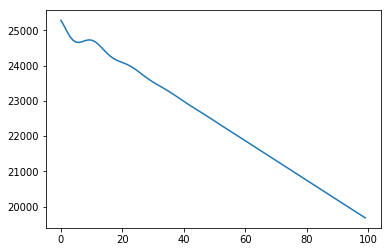

In [35]:
# walk-forward validation on the test data
#predictions_ext = list()
import numpy as np

predictions_ext = predictions.copy()
N = 500
X_s = [test_scaled[N-1, 0:-1]]
print(X_s)
for i in range(100):
    # make one-step forecast
    #X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    X = np.array([X_s[i-1]])
    yhat = forecast_lstm(lstm_model, 1, X)
    X_s.append(yhat)
    print(yhat)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    print(N-1+i, yhat,predictions_ext[N-1+i])
    #yhat = inverse_difference(predictions[N-1+i], yhat, 100+1-i)
    yhat = predictions_ext[N-1+i] + yhat
    # store forecast
    predictions_ext.append(yhat)
    #expected = raw_values[len(train) + i + 1]
    print('TestData_Day#=%d, Predicted=%f' % (i+1, yhat))

# line plot of observed vs predicted
#pyplot.plot(raw_values[-nn:])
pyplot.plot(predictions_ext[500:])
pyplot.show()

In [ ]:
# report performance
rmse = sqrt(mean_squared_error(raw_values[-nn:], predictions))
#print('%d) Test RMSE: %.3f' % (r+1, rmse))
print('Test RMSE:', rmse)
#error_scores.append(rmse)



TestData_Day#=1, Predicted=11375.487758, Expected=10862.000000
TestData_Day#=2, Predicted=11572.014625, Expected=9871.000000
TestData_Day#=3, Predicted=10853.296364, Expected=10910.000000
TestData_Day#=4, Predicted=12091.443306, Expected=13000.000000
TestData_Day#=5, Predicted=12579.051066, Expected=12547.000000
TestData_Day#=6, Predicted=12140.886474, Expected=12218.000000
TestData_Day#=7, Predicted=11753.136876, Expected=12012.000000
TestData_Day#=8, Predicted=11568.347954, Expected=11573.000000
TestData_Day#=9, Predicted=11217.010511, Expected=12130.000000
TestData_Day#=10, Predicted=12018.821586, Expected=14136.000000
TestData_Day#=11, Predicted=13296.877321, Expected=13184.000000
TestData_Day#=12, Predicted=12814.747414, Expected=12524.000000
TestData_Day#=13, Predicted=12159.713596, Expected=12029.000000
TestData_Day#=14, Predicted=12224.183215, Expected=11397.000000
TestData_Day#=15, Predicted=12190.354831, Expected=10349.000000
TestData_Day#=16, Predicted=11742.884206, Expected

TestData_Day#=1, Predicted=11411.770096, Expected=10862.000000
TestData_Day#=2, Predicted=11266.095959, Expected=9871.000000
TestData_Day#=3, Predicted=10289.810392, Expected=10910.000000
TestData_Day#=4, Predicted=11493.807886, Expected=13000.000000
TestData_Day#=5, Predicted=12792.532380, Expected=12547.000000
TestData_Day#=6, Predicted=11806.183567, Expected=12218.000000
TestData_Day#=7, Predicted=11763.941325, Expected=12012.000000
TestData_Day#=8, Predicted=11671.202892, Expected=11573.000000
TestData_Day#=9, Predicted=11385.345276, Expected=12130.000000
TestData_Day#=10, Predicted=12056.580526, Expected=14136.000000
TestData_Day#=11, Predicted=13511.727220, Expected=13184.000000
TestData_Day#=12, Predicted=12346.269878, Expected=12524.000000
TestData_Day#=13, Predicted=12263.532056, Expected=12029.000000
TestData_Day#=14, Predicted=12054.100627, Expected=11397.000000
TestData_Day#=15, Predicted=11674.598270, Expected=10349.000000
TestData_Day#=16, Predicted=10827.314223, Expected

TestData_Day#=1, Predicted=11387.927948, Expected=10862.000000
TestData_Day#=2, Predicted=11269.846981, Expected=9871.000000
TestData_Day#=3, Predicted=10573.619303, Expected=10910.000000
TestData_Day#=4, Predicted=11688.733338, Expected=13000.000000
TestData_Day#=5, Predicted=13135.987415, Expected=12547.000000
TestData_Day#=6, Predicted=12146.724976, Expected=12218.000000
TestData_Day#=7, Predicted=11470.275027, Expected=12012.000000
TestData_Day#=8, Predicted=11367.378009, Expected=11573.000000
TestData_Day#=9, Predicted=11354.164701, Expected=12130.000000
TestData_Day#=10, Predicted=12204.471433, Expected=14136.000000
TestData_Day#=11, Predicted=14025.528996, Expected=13184.000000
TestData_Day#=12, Predicted=13104.412790, Expected=12524.000000
TestData_Day#=13, Predicted=12502.673544, Expected=12029.000000
TestData_Day#=14, Predicted=12134.278485, Expected=11397.000000
TestData_Day#=15, Predicted=11689.841243, Expected=10349.000000
TestData_Day#=16, Predicted=10873.903272, Expected

TestData_Day#=1, Predicted=11459.713419, Expected=10862.000000
TestData_Day#=2, Predicted=11788.075326, Expected=9871.000000
TestData_Day#=3, Predicted=11154.122103, Expected=10910.000000
TestData_Day#=4, Predicted=12375.033473, Expected=13000.000000
TestData_Day#=5, Predicted=12396.615102, Expected=12547.000000
TestData_Day#=6, Predicted=12339.288723, Expected=12218.000000
TestData_Day#=7, Predicted=12162.608613, Expected=12012.000000
TestData_Day#=8, Predicted=11998.696943, Expected=11573.000000
TestData_Day#=9, Predicted=11575.943931, Expected=12130.000000
TestData_Day#=10, Predicted=12285.088838, Expected=14136.000000
TestData_Day#=11, Predicted=13581.931782, Expected=13184.000000
TestData_Day#=12, Predicted=12613.615001, Expected=12524.000000
TestData_Day#=13, Predicted=12014.009529, Expected=12029.000000
TestData_Day#=14, Predicted=11921.074753, Expected=11397.000000
TestData_Day#=15, Predicted=11867.458091, Expected=10349.000000
TestData_Day#=16, Predicted=11356.901530, Expected

TestData_Day#=1, Predicted=11285.807778, Expected=10862.000000
TestData_Day#=2, Predicted=11053.236420, Expected=9871.000000
TestData_Day#=3, Predicted=10098.042872, Expected=10910.000000
TestData_Day#=4, Predicted=11309.065345, Expected=13000.000000
TestData_Day#=5, Predicted=12796.028849, Expected=12547.000000
TestData_Day#=6, Predicted=12174.787553, Expected=12218.000000
TestData_Day#=7, Predicted=11981.552779, Expected=12012.000000
TestData_Day#=8, Predicted=11905.629276, Expected=11573.000000
TestData_Day#=9, Predicted=11471.356808, Expected=12130.000000
TestData_Day#=10, Predicted=12106.888911, Expected=14136.000000
TestData_Day#=11, Predicted=13723.249683, Expected=13184.000000
TestData_Day#=12, Predicted=12635.814162, Expected=12524.000000
TestData_Day#=13, Predicted=12216.128110, Expected=12029.000000
TestData_Day#=14, Predicted=11932.441136, Expected=11397.000000
TestData_Day#=15, Predicted=11332.162267, Expected=10349.000000
TestData_Day#=16, Predicted=10381.199404, Expected

TestData_Day#=1, Predicted=11239.188161, Expected=10862.000000
TestData_Day#=2, Predicted=11253.050309, Expected=9871.000000
TestData_Day#=3, Predicted=10275.539688, Expected=10910.000000
TestData_Day#=4, Predicted=11630.336886, Expected=13000.000000
TestData_Day#=5, Predicted=12623.302912, Expected=12547.000000
TestData_Day#=6, Predicted=11984.069839, Expected=12218.000000
TestData_Day#=7, Predicted=11713.416906, Expected=12012.000000
TestData_Day#=8, Predicted=11659.052710, Expected=11573.000000
TestData_Day#=9, Predicted=11313.720771, Expected=12130.000000
TestData_Day#=10, Predicted=11954.177121, Expected=14136.000000
TestData_Day#=11, Predicted=13185.088049, Expected=13184.000000
TestData_Day#=12, Predicted=12651.333656, Expected=12524.000000
TestData_Day#=13, Predicted=12093.817249, Expected=12029.000000
TestData_Day#=14, Predicted=11879.810096, Expected=11397.000000
TestData_Day#=15, Predicted=11423.542775, Expected=10349.000000
TestData_Day#=16, Predicted=10580.468851, Expected

TestData_Day#=1, Predicted=11635.980469, Expected=10862.000000
TestData_Day#=2, Predicted=11481.297708, Expected=9871.000000
TestData_Day#=3, Predicted=10439.416611, Expected=10910.000000
TestData_Day#=4, Predicted=11899.902302, Expected=13000.000000
TestData_Day#=5, Predicted=13559.066973, Expected=12547.000000
TestData_Day#=6, Predicted=12861.773012, Expected=12218.000000
TestData_Day#=7, Predicted=12610.172648, Expected=12012.000000
TestData_Day#=8, Predicted=12528.103966, Expected=11573.000000
TestData_Day#=9, Predicted=12093.009298, Expected=12130.000000
TestData_Day#=10, Predicted=12875.839217, Expected=14136.000000
TestData_Day#=11, Predicted=14618.735255, Expected=13184.000000
TestData_Day#=12, Predicted=13286.565226, Expected=12524.000000
TestData_Day#=13, Predicted=12829.437981, Expected=12029.000000
TestData_Day#=14, Predicted=12571.258875, Expected=11397.000000
TestData_Day#=15, Predicted=11971.691480, Expected=10349.000000
TestData_Day#=16, Predicted=10909.250682, Expected

TestData_Day#=1, Predicted=11203.081807, Expected=10862.000000
TestData_Day#=2, Predicted=11003.711363, Expected=9871.000000
TestData_Day#=3, Predicted=9886.359090, Expected=10910.000000
TestData_Day#=4, Predicted=10978.967818, Expected=13000.000000
TestData_Day#=5, Predicted=12851.207001, Expected=12547.000000
TestData_Day#=6, Predicted=12707.076223, Expected=12218.000000
TestData_Day#=7, Predicted=12028.552103, Expected=12012.000000
TestData_Day#=8, Predicted=12144.923484, Expected=11573.000000
TestData_Day#=9, Predicted=11463.290944, Expected=12130.000000
TestData_Day#=10, Predicted=12218.835135, Expected=14136.000000
TestData_Day#=11, Predicted=13933.568707, Expected=13184.000000
TestData_Day#=12, Predicted=13393.773494, Expected=12524.000000
TestData_Day#=13, Predicted=12308.845576, Expected=12029.000000
TestData_Day#=14, Predicted=12230.785904, Expected=11397.000000
TestData_Day#=15, Predicted=11305.796331, Expected=10349.000000
TestData_Day#=16, Predicted=10537.861935, Expected=

TestData_Day#=1, Predicted=11292.232540, Expected=10862.000000
TestData_Day#=2, Predicted=11063.365499, Expected=9871.000000
TestData_Day#=3, Predicted=9894.989715, Expected=10910.000000
TestData_Day#=4, Predicted=11266.349705, Expected=13000.000000
TestData_Day#=5, Predicted=13130.681281, Expected=12547.000000
TestData_Day#=6, Predicted=12387.749514, Expected=12218.000000
TestData_Day#=7, Predicted=12311.015162, Expected=12012.000000
TestData_Day#=8, Predicted=12136.373430, Expected=11573.000000
TestData_Day#=9, Predicted=11674.975138, Expected=12130.000000
TestData_Day#=10, Predicted=12404.339154, Expected=14136.000000
TestData_Day#=11, Predicted=14303.012150, Expected=13184.000000
TestData_Day#=12, Predicted=12932.656531, Expected=12524.000000
TestData_Day#=13, Predicted=12615.500453, Expected=12029.000000
TestData_Day#=14, Predicted=12142.442647, Expected=11397.000000
TestData_Day#=15, Predicted=11502.665673, Expected=10349.000000
TestData_Day#=16, Predicted=10389.241120, Expected=

TestData_Day#=1, Predicted=11342.084827, Expected=10862.000000
TestData_Day#=2, Predicted=11222.834582, Expected=9871.000000
TestData_Day#=3, Predicted=10375.401636, Expected=10910.000000
TestData_Day#=4, Predicted=11435.957643, Expected=13000.000000
TestData_Day#=5, Predicted=12842.244434, Expected=12547.000000
TestData_Day#=6, Predicted=12049.823802, Expected=12218.000000
TestData_Day#=7, Predicted=11676.594367, Expected=12012.000000
TestData_Day#=8, Predicted=11675.981428, Expected=11573.000000
TestData_Day#=9, Predicted=11717.369731, Expected=12130.000000
TestData_Day#=10, Predicted=12604.010866, Expected=14136.000000
TestData_Day#=11, Predicted=14358.000006, Expected=13184.000000
TestData_Day#=12, Predicted=13077.072878, Expected=12524.000000
TestData_Day#=13, Predicted=12472.540508, Expected=12029.000000
TestData_Day#=14, Predicted=12005.449128, Expected=11397.000000
TestData_Day#=15, Predicted=11473.459378, Expected=10349.000000
TestData_Day#=16, Predicted=10601.631310, Expected

TestData_Day#=1, Predicted=11875.540302, Expected=10862.000000
TestData_Day#=2, Predicted=11896.352571, Expected=9871.000000
TestData_Day#=3, Predicted=10971.198178, Expected=10910.000000
TestData_Day#=4, Predicted=12348.198895, Expected=13000.000000
TestData_Day#=5, Predicted=13400.485230, Expected=12547.000000
TestData_Day#=6, Predicted=12464.814203, Expected=12218.000000
TestData_Day#=7, Predicted=12238.133974, Expected=12012.000000
TestData_Day#=8, Predicted=12176.267086, Expected=11573.000000
TestData_Day#=9, Predicted=11839.795058, Expected=12130.000000
TestData_Day#=10, Predicted=12555.142745, Expected=14136.000000
TestData_Day#=11, Predicted=13767.707020, Expected=13184.000000
TestData_Day#=12, Predicted=12700.568293, Expected=12524.000000
TestData_Day#=13, Predicted=12213.993689, Expected=12029.000000
TestData_Day#=14, Predicted=12008.830101, Expected=11397.000000
TestData_Day#=15, Predicted=11645.751658, Expected=10349.000000
TestData_Day#=16, Predicted=10936.226965, Expected

TestData_Day#=200, Predicted=8376.501057, Expected=7552.000000
11) Test RMSE: 806.792
TestData_Day#=1, Predicted=11462.923297, Expected=10862.000000
TestData_Day#=2, Predicted=11375.445716, Expected=9871.000000
TestData_Day#=3, Predicted=10428.014418, Expected=10910.000000
TestData_Day#=4, Predicted=11664.784116, Expected=13000.000000
TestData_Day#=5, Predicted=12747.254433, Expected=12547.000000
TestData_Day#=6, Predicted=11629.497930, Expected=12218.000000
TestData_Day#=7, Predicted=11621.058004, Expected=12012.000000
TestData_Day#=8, Predicted=11582.399651, Expected=11573.000000
TestData_Day#=9, Predicted=11345.252902, Expected=12130.000000
TestData_Day#=10, Predicted=11976.686963, Expected=14136.000000
TestData_Day#=11, Predicted=13293.659249, Expected=13184.000000
TestData_Day#=12, Predicted=12243.823088, Expected=12524.000000
TestData_Day#=13, Predicted=12117.480380, Expected=12029.000000
TestData_Day#=14, Predicted=11999.835494, Expected=11397.000000
TestData_Day#=15, Predicted=

TestData_Day#=1, Predicted=11445.985508, Expected=10862.000000
TestData_Day#=2, Predicted=11595.687739, Expected=9871.000000
TestData_Day#=3, Predicted=10509.780665, Expected=10910.000000
TestData_Day#=4, Predicted=12128.877901, Expected=13000.000000
TestData_Day#=5, Predicted=12975.013695, Expected=12547.000000
TestData_Day#=6, Predicted=12309.589933, Expected=12218.000000
TestData_Day#=7, Predicted=11910.192131, Expected=12012.000000
TestData_Day#=8, Predicted=11818.015633, Expected=11573.000000
TestData_Day#=9, Predicted=11442.108048, Expected=12130.000000
TestData_Day#=10, Predicted=12105.218597, Expected=14136.000000
TestData_Day#=11, Predicted=13352.420633, Expected=13184.000000
TestData_Day#=12, Predicted=12731.252957, Expected=12524.000000
TestData_Day#=13, Predicted=12005.932298, Expected=12029.000000
TestData_Day#=14, Predicted=11821.589038, Expected=11397.000000
TestData_Day#=15, Predicted=11392.064594, Expected=10349.000000
TestData_Day#=16, Predicted=10582.425640, Expected

TestData_Day#=189, Predicted=7981.324829, Expected=7900.000000
TestData_Day#=190, Predicted=7513.324610, Expected=6922.000000
TestData_Day#=191, Predicted=6708.358813, Expected=6460.000000
TestData_Day#=192, Predicted=6802.576797, Expected=7756.000000
TestData_Day#=193, Predicted=7912.898031, Expected=8484.000000
TestData_Day#=194, Predicted=8295.819328, Expected=7473.000000
TestData_Day#=195, Predicted=6961.923824, Expected=7325.000000
TestData_Day#=196, Predicted=7262.287736, Expected=7189.000000
TestData_Day#=197, Predicted=7113.993198, Expected=6169.000000
TestData_Day#=198, Predicted=6057.535465, Expected=6026.000000
TestData_Day#=199, Predicted=6553.786037, Expected=7672.000000
TestData_Day#=200, Predicted=7677.353165, Expected=7552.000000
13) Test RMSE: 797.922
TestData_Day#=1, Predicted=11542.745005, Expected=10862.000000
TestData_Day#=2, Predicted=11575.461504, Expected=9871.000000
TestData_Day#=3, Predicted=10652.407843, Expected=10910.000000
TestData_Day#=4, Predicted=12134.

TestData_Day#=1, Predicted=11314.282574, Expected=10862.000000
TestData_Day#=2, Predicted=11619.541901, Expected=9871.000000
TestData_Day#=3, Predicted=10913.754912, Expected=10910.000000
TestData_Day#=4, Predicted=12346.734955, Expected=13000.000000
TestData_Day#=5, Predicted=12587.718561, Expected=12547.000000
TestData_Day#=6, Predicted=12027.864970, Expected=12218.000000
TestData_Day#=7, Predicted=12023.912092, Expected=12012.000000
TestData_Day#=8, Predicted=11664.567162, Expected=11573.000000
TestData_Day#=9, Predicted=11265.350505, Expected=12130.000000
TestData_Day#=10, Predicted=12336.306119, Expected=14136.000000
TestData_Day#=11, Predicted=13809.015732, Expected=13184.000000
TestData_Day#=12, Predicted=12892.332515, Expected=12524.000000
TestData_Day#=13, Predicted=12405.842899, Expected=12029.000000
TestData_Day#=14, Predicted=12393.550148, Expected=11397.000000
TestData_Day#=15, Predicted=12212.028397, Expected=10349.000000
TestData_Day#=16, Predicted=11492.071779, Expected

TestData_Day#=1, Predicted=11611.915810, Expected=10862.000000
TestData_Day#=2, Predicted=11409.155087, Expected=9871.000000
TestData_Day#=3, Predicted=10432.337682, Expected=10910.000000
TestData_Day#=4, Predicted=11760.257071, Expected=13000.000000
TestData_Day#=5, Predicted=13172.421236, Expected=12547.000000
TestData_Day#=6, Predicted=12434.409004, Expected=12218.000000
TestData_Day#=7, Predicted=12223.873518, Expected=12012.000000
TestData_Day#=8, Predicted=12163.428635, Expected=11573.000000
TestData_Day#=9, Predicted=11763.061193, Expected=12130.000000
TestData_Day#=10, Predicted=12419.819482, Expected=14136.000000
TestData_Day#=11, Predicted=13809.765960, Expected=13184.000000
TestData_Day#=12, Predicted=12718.010533, Expected=12524.000000
TestData_Day#=13, Predicted=12309.850592, Expected=12029.000000
TestData_Day#=14, Predicted=12075.837213, Expected=11397.000000
TestData_Day#=15, Predicted=11567.751393, Expected=10349.000000
TestData_Day#=16, Predicted=10641.825105, Expected

TestData_Day#=190, Predicted=7949.018045, Expected=6922.000000
TestData_Day#=191, Predicted=7090.571385, Expected=6460.000000
TestData_Day#=192, Predicted=6944.066913, Expected=7756.000000
TestData_Day#=193, Predicted=8281.703445, Expected=8484.000000
TestData_Day#=194, Predicted=8552.736471, Expected=7473.000000
TestData_Day#=195, Predicted=7352.325413, Expected=7325.000000
TestData_Day#=196, Predicted=7590.308266, Expected=7189.000000
TestData_Day#=197, Predicted=7525.151741, Expected=6169.000000
TestData_Day#=198, Predicted=6411.862445, Expected=6026.000000
TestData_Day#=199, Predicted=6592.599996, Expected=7672.000000
TestData_Day#=200, Predicted=8142.504384, Expected=7552.000000
16) Test RMSE: 844.892
TestData_Day#=1, Predicted=11351.077374, Expected=10862.000000
TestData_Day#=2, Predicted=11073.164166, Expected=9871.000000
TestData_Day#=3, Predicted=10048.099294, Expected=10910.000000
TestData_Day#=4, Predicted=11229.807396, Expected=13000.000000
TestData_Day#=5, Predicted=12976.

TestData_Day#=188, Predicted=8315.407511, Expected=8376.000000
TestData_Day#=189, Predicted=8294.901203, Expected=7900.000000
TestData_Day#=190, Predicted=7871.581128, Expected=6922.000000
TestData_Day#=191, Predicted=6953.694305, Expected=6460.000000
TestData_Day#=192, Predicted=6621.792241, Expected=7756.000000
TestData_Day#=193, Predicted=7946.748990, Expected=8484.000000
TestData_Day#=194, Predicted=8515.577807, Expected=7473.000000
TestData_Day#=195, Predicted=7459.617609, Expected=7325.000000
TestData_Day#=196, Predicted=7457.669874, Expected=7189.000000
TestData_Day#=197, Predicted=7331.356519, Expected=6169.000000
TestData_Day#=198, Predicted=6281.283440, Expected=6026.000000
TestData_Day#=199, Predicted=6273.059316, Expected=7672.000000
TestData_Day#=200, Predicted=7842.896750, Expected=7552.000000
17) Test RMSE: 920.308
TestData_Day#=1, Predicted=11420.555737, Expected=10862.000000
TestData_Day#=2, Predicted=11876.235885, Expected=9871.000000
TestData_Day#=3, Predicted=11289.

TestData_Day#=186, Predicted=8454.721989, Expected=8332.000000
TestData_Day#=187, Predicted=8014.792784, Expected=8399.000000
TestData_Day#=188, Predicted=8045.632009, Expected=8376.000000
TestData_Day#=189, Predicted=7927.493471, Expected=7900.000000
TestData_Day#=190, Predicted=7364.707564, Expected=6922.000000
TestData_Day#=191, Predicted=6531.395189, Expected=6460.000000
TestData_Day#=192, Predicted=6859.205519, Expected=7756.000000
TestData_Day#=193, Predicted=8091.038001, Expected=8484.000000
TestData_Day#=194, Predicted=8089.173582, Expected=7473.000000
TestData_Day#=195, Predicted=6988.119018, Expected=7325.000000
TestData_Day#=196, Predicted=7258.688963, Expected=7189.000000
TestData_Day#=197, Predicted=7066.168375, Expected=6169.000000
TestData_Day#=198, Predicted=6239.813115, Expected=6026.000000
TestData_Day#=199, Predicted=7096.638561, Expected=7672.000000
TestData_Day#=200, Predicted=7936.324807, Expected=7552.000000
18) Test RMSE: 707.340
TestData_Day#=1, Predicted=11583

TestData_Day#=188, Predicted=8029.369296, Expected=8376.000000
TestData_Day#=189, Predicted=7885.242527, Expected=7900.000000
TestData_Day#=190, Predicted=7393.937270, Expected=6922.000000
TestData_Day#=191, Predicted=6661.801568, Expected=6460.000000
TestData_Day#=192, Predicted=6684.781704, Expected=7756.000000
TestData_Day#=193, Predicted=7870.744739, Expected=8484.000000
TestData_Day#=194, Predicted=8056.546499, Expected=7473.000000
TestData_Day#=195, Predicted=6988.487683, Expected=7325.000000
TestData_Day#=196, Predicted=7102.580651, Expected=7189.000000
TestData_Day#=197, Predicted=7045.614497, Expected=6169.000000
TestData_Day#=198, Predicted=6225.802499, Expected=6026.000000
TestData_Day#=199, Predicted=6544.376089, Expected=7672.000000
TestData_Day#=200, Predicted=7717.295058, Expected=7552.000000
19) Test RMSE: 777.234
TestData_Day#=1, Predicted=11356.380092, Expected=10862.000000
TestData_Day#=2, Predicted=11002.296779, Expected=9871.000000
TestData_Day#=3, Predicted=10000.

TestData_Day#=193, Predicted=7900.781891, Expected=8484.000000
TestData_Day#=194, Predicted=8593.683851, Expected=7473.000000
TestData_Day#=195, Predicted=7562.674710, Expected=7325.000000
TestData_Day#=196, Predicted=7456.750141, Expected=7189.000000
TestData_Day#=197, Predicted=7329.896349, Expected=6169.000000
TestData_Day#=198, Predicted=6291.620306, Expected=6026.000000
TestData_Day#=199, Predicted=6192.285952, Expected=7672.000000
TestData_Day#=200, Predicted=7799.670592, Expected=7552.000000
20) Test RMSE: 968.668
TestData_Day#=1, Predicted=11345.690197, Expected=10862.000000
TestData_Day#=2, Predicted=11096.782741, Expected=9871.000000
TestData_Day#=3, Predicted=10049.528367, Expected=10910.000000
TestData_Day#=4, Predicted=11257.637920, Expected=13000.000000
TestData_Day#=5, Predicted=13037.705847, Expected=12547.000000
TestData_Day#=6, Predicted=12263.797405, Expected=12218.000000
TestData_Day#=7, Predicted=12115.583669, Expected=12012.000000
TestData_Day#=8, Predicted=11971.

TestData_Day#=187, Predicted=8198.838694, Expected=8399.000000
TestData_Day#=188, Predicted=8311.395399, Expected=8376.000000
TestData_Day#=189, Predicted=8294.877527, Expected=7900.000000
TestData_Day#=190, Predicted=7822.832332, Expected=6922.000000
TestData_Day#=191, Predicted=6894.053481, Expected=6460.000000
TestData_Day#=192, Predicted=6596.145494, Expected=7756.000000
TestData_Day#=193, Predicted=7910.250854, Expected=8484.000000
TestData_Day#=194, Predicted=8421.393044, Expected=7473.000000
TestData_Day#=195, Predicted=7273.339862, Expected=7325.000000
TestData_Day#=196, Predicted=7360.544745, Expected=7189.000000
TestData_Day#=197, Predicted=7225.932060, Expected=6169.000000
TestData_Day#=198, Predicted=6166.023149, Expected=6026.000000
TestData_Day#=199, Predicted=6219.596181, Expected=7672.000000
TestData_Day#=200, Predicted=7791.522568, Expected=7552.000000
21) Test RMSE: 905.181
TestData_Day#=1, Predicted=11283.174736, Expected=10862.000000
TestData_Day#=2, Predicted=11114

TestData_Day#=183, Predicted=7015.142100, Expected=6512.000000
TestData_Day#=184, Predicted=6729.907854, Expected=6289.000000
TestData_Day#=185, Predicted=6542.808305, Expected=8142.000000
TestData_Day#=186, Predicted=8299.960059, Expected=8332.000000
TestData_Day#=187, Predicted=8036.270283, Expected=8399.000000
TestData_Day#=188, Predicted=8278.205970, Expected=8376.000000
TestData_Day#=189, Predicted=8238.471788, Expected=7900.000000
TestData_Day#=190, Predicted=7778.421229, Expected=6922.000000
TestData_Day#=191, Predicted=6893.443133, Expected=6460.000000
TestData_Day#=192, Predicted=6676.101370, Expected=7756.000000
TestData_Day#=193, Predicted=7975.240807, Expected=8484.000000
TestData_Day#=194, Predicted=8280.600973, Expected=7473.000000
TestData_Day#=195, Predicted=7207.580186, Expected=7325.000000
TestData_Day#=196, Predicted=7469.729473, Expected=7189.000000
TestData_Day#=197, Predicted=7220.377204, Expected=6169.000000
TestData_Day#=198, Predicted=6149.876698, Expected=6026

TestData_Day#=185, Predicted=6440.951286, Expected=8142.000000
TestData_Day#=186, Predicted=8453.708256, Expected=8332.000000
TestData_Day#=187, Predicted=8392.466059, Expected=8399.000000
TestData_Day#=188, Predicted=8551.556274, Expected=8376.000000
TestData_Day#=189, Predicted=8531.470019, Expected=7900.000000
TestData_Day#=190, Predicted=7957.502370, Expected=6922.000000
TestData_Day#=191, Predicted=6852.123937, Expected=6460.000000
TestData_Day#=192, Predicted=6571.031175, Expected=7756.000000
TestData_Day#=193, Predicted=8103.155437, Expected=8484.000000
TestData_Day#=194, Predicted=8696.613853, Expected=7473.000000
TestData_Day#=195, Predicted=7293.334338, Expected=7325.000000
TestData_Day#=196, Predicted=7482.415734, Expected=7189.000000
TestData_Day#=197, Predicted=7322.758052, Expected=6169.000000
TestData_Day#=198, Predicted=6049.952968, Expected=6026.000000
TestData_Day#=199, Predicted=6205.129350, Expected=7672.000000
TestData_Day#=200, Predicted=7990.364306, Expected=7552

TestData_Day#=182, Predicted=7920.156829, Expected=6989.000000
TestData_Day#=183, Predicted=6995.541291, Expected=6512.000000
TestData_Day#=184, Predicted=6880.088316, Expected=6289.000000
TestData_Day#=185, Predicted=6631.783171, Expected=8142.000000
TestData_Day#=186, Predicted=8390.761552, Expected=8332.000000
TestData_Day#=187, Predicted=7851.324900, Expected=8399.000000
TestData_Day#=188, Predicted=8171.414633, Expected=8376.000000
TestData_Day#=189, Predicted=8070.977716, Expected=7900.000000
TestData_Day#=190, Predicted=7667.131468, Expected=6922.000000
TestData_Day#=191, Predicted=6855.178092, Expected=6460.000000
TestData_Day#=192, Predicted=6711.336640, Expected=7756.000000
TestData_Day#=193, Predicted=7943.535225, Expected=8484.000000
TestData_Day#=194, Predicted=8096.836061, Expected=7473.000000
TestData_Day#=195, Predicted=7074.747965, Expected=7325.000000
TestData_Day#=196, Predicted=7373.097193, Expected=7189.000000
TestData_Day#=197, Predicted=7085.111365, Expected=6169

TestData_Day#=170, Predicted=7847.621858, Expected=7391.000000
TestData_Day#=171, Predicted=7686.526703, Expected=9223.000000
TestData_Day#=172, Predicted=9370.759480, Expected=9379.000000
TestData_Day#=173, Predicted=9458.798181, Expected=8943.000000
TestData_Day#=174, Predicted=9011.280021, Expected=9176.000000
TestData_Day#=175, Predicted=9367.014379, Expected=8714.000000
TestData_Day#=176, Predicted=8833.764163, Expected=7781.000000
TestData_Day#=177, Predicted=7894.303886, Expected=7384.000000
TestData_Day#=178, Predicted=7640.553015, Expected=9293.000000
TestData_Day#=179, Predicted=9397.601054, Expected=9323.000000
TestData_Day#=180, Predicted=9365.900430, Expected=7923.000000
TestData_Day#=181, Predicted=7865.336727, Expected=7725.000000
TestData_Day#=182, Predicted=7939.966664, Expected=6989.000000
TestData_Day#=183, Predicted=7153.404316, Expected=6512.000000
TestData_Day#=184, Predicted=6765.523597, Expected=6289.000000
TestData_Day#=185, Predicted=6602.456786, Expected=8142

TestData_Day#=178, Predicted=7820.429853, Expected=9293.000000
TestData_Day#=179, Predicted=9545.564050, Expected=9323.000000
TestData_Day#=180, Predicted=9119.402609, Expected=7923.000000
TestData_Day#=181, Predicted=7858.597397, Expected=7725.000000
TestData_Day#=182, Predicted=7979.187954, Expected=6989.000000
TestData_Day#=183, Predicted=7321.363142, Expected=6512.000000
TestData_Day#=184, Predicted=6977.542797, Expected=6289.000000
TestData_Day#=185, Predicted=6754.179992, Expected=8142.000000
TestData_Day#=186, Predicted=8137.121841, Expected=8332.000000
TestData_Day#=187, Predicted=7641.156122, Expected=8399.000000
TestData_Day#=188, Predicted=7530.054258, Expected=8376.000000
TestData_Day#=189, Predicted=7532.002724, Expected=7900.000000
TestData_Day#=190, Predicted=7374.913621, Expected=6922.000000
TestData_Day#=191, Predicted=6955.299067, Expected=6460.000000
TestData_Day#=192, Predicted=7012.002650, Expected=7756.000000
TestData_Day#=193, Predicted=8373.949442, Expected=8484

TestData_Day#=177, Predicted=7585.798353, Expected=7384.000000
TestData_Day#=178, Predicted=7547.944685, Expected=9293.000000
TestData_Day#=179, Predicted=9374.502597, Expected=9323.000000
TestData_Day#=180, Predicted=9253.553295, Expected=7923.000000
TestData_Day#=181, Predicted=7857.259968, Expected=7725.000000
TestData_Day#=182, Predicted=7988.354540, Expected=6989.000000
TestData_Day#=183, Predicted=7451.960523, Expected=6512.000000
TestData_Day#=184, Predicted=7321.215515, Expected=6289.000000
TestData_Day#=185, Predicted=7321.785327, Expected=8142.000000
TestData_Day#=186, Predicted=8739.717435, Expected=8332.000000
TestData_Day#=187, Predicted=8063.038778, Expected=8399.000000
TestData_Day#=188, Predicted=7648.970423, Expected=8376.000000
TestData_Day#=189, Predicted=7554.955735, Expected=7900.000000
TestData_Day#=190, Predicted=7334.936596, Expected=6922.000000
TestData_Day#=191, Predicted=6684.173532, Expected=6460.000000
TestData_Day#=192, Predicted=6594.891345, Expected=7756

TestData_Day#=168, Predicted=8994.410098, Expected=8133.000000
TestData_Day#=169, Predicted=8225.415533, Expected=7623.000000
TestData_Day#=170, Predicted=7845.518534, Expected=7391.000000
TestData_Day#=171, Predicted=7684.238914, Expected=9223.000000
TestData_Day#=172, Predicted=9403.778226, Expected=9379.000000
TestData_Day#=173, Predicted=9453.521260, Expected=8943.000000
TestData_Day#=174, Predicted=8920.747038, Expected=9176.000000
TestData_Day#=175, Predicted=9260.880154, Expected=8714.000000
TestData_Day#=176, Predicted=8722.763292, Expected=7781.000000
TestData_Day#=177, Predicted=7825.897681, Expected=7384.000000
TestData_Day#=178, Predicted=7631.531669, Expected=9293.000000
TestData_Day#=179, Predicted=9441.019568, Expected=9323.000000
TestData_Day#=180, Predicted=9367.186089, Expected=7923.000000
TestData_Day#=181, Predicted=7775.582655, Expected=7725.000000
TestData_Day#=182, Predicted=7937.383448, Expected=6989.000000
TestData_Day#=183, Predicted=7164.717927, Expected=6512

TestData_Day#=164, Predicted=8658.980577, Expected=9930.000000
TestData_Day#=165, Predicted=10045.355499, Expected=9658.000000
TestData_Day#=166, Predicted=9343.852298, Expected=9080.000000
TestData_Day#=167, Predicted=9068.210768, Expected=8885.000000
TestData_Day#=168, Predicted=8993.192936, Expected=8133.000000
TestData_Day#=169, Predicted=8280.506812, Expected=7623.000000
TestData_Day#=170, Predicted=7977.676446, Expected=7391.000000
TestData_Day#=171, Predicted=7782.758132, Expected=9223.000000
TestData_Day#=172, Predicted=9463.981751, Expected=9379.000000
TestData_Day#=173, Predicted=9002.947479, Expected=8943.000000
TestData_Day#=174, Predicted=8779.323004, Expected=9176.000000
TestData_Day#=175, Predicted=9105.119216, Expected=8714.000000
TestData_Day#=176, Predicted=8620.752552, Expected=7781.000000
TestData_Day#=177, Predicted=7903.361042, Expected=7384.000000
TestData_Day#=178, Predicted=7736.620475, Expected=9293.000000
TestData_Day#=179, Predicted=9495.145999, Expected=932

TestData_Day#=171, Predicted=7512.595855, Expected=9223.000000
TestData_Day#=172, Predicted=9287.687254, Expected=9379.000000
TestData_Day#=173, Predicted=9249.543069, Expected=8943.000000
TestData_Day#=174, Predicted=8882.128675, Expected=9176.000000
TestData_Day#=175, Predicted=9135.665944, Expected=8714.000000
TestData_Day#=176, Predicted=8665.052045, Expected=7781.000000
TestData_Day#=177, Predicted=7805.767094, Expected=7384.000000
TestData_Day#=178, Predicted=7482.469893, Expected=9293.000000
TestData_Day#=179, Predicted=9333.545263, Expected=9323.000000
TestData_Day#=180, Predicted=9172.716794, Expected=7923.000000
TestData_Day#=181, Predicted=7868.938504, Expected=7725.000000
TestData_Day#=182, Predicted=7790.860480, Expected=6989.000000
TestData_Day#=183, Predicted=7042.419582, Expected=6512.000000
TestData_Day#=184, Predicted=6645.404553, Expected=6289.000000
TestData_Day#=185, Predicted=6425.993962, Expected=8142.000000
TestData_Day#=186, Predicted=8222.520492, Expected=8332

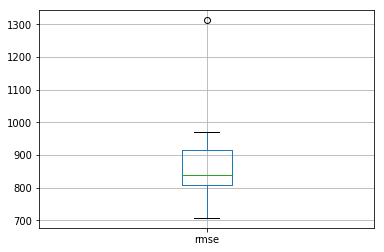

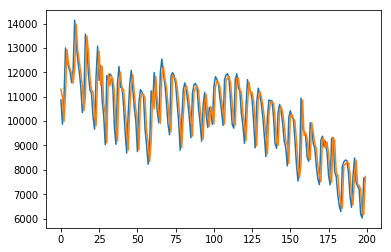

In [36]:
# Multiple model runs
# ----------------------

from pandas import DataFrame
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot
import numpy
 
# date-time parsing function for loading the dataset
def parser(x):
    #return datetime.strptime('190'+x, '%Y-%m')
    return datetime.strptime(x, '%Y-%m-%d')
    #return datetime.strptime(x, '%mm/%dd/%YY')
# ValueError: time data '1902016-01-01' does not match format '%Y-%m'

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1):
    df = DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df
 
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)
 
# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = numpy.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]
 
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]
 
# load dataset
series = read_csv('AMRNotPaid.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)

# transform data to be stationary
raw_values = series.values
diff_values = difference(raw_values, 1)
 
# transform data to be supervised learning
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values
 
# split data into train and test-sets
# take last 200 rows as test data
train, test = supervised_values[0:-200], supervised_values[-200:]
 
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)
 
# repeat experiment
repeats = 30
error_scores = list()
for r in range(repeats):
    # fit the model
    lstm_model = fit_lstm(train_scaled, 1, 100, 4)
    # forecast the entire training dataset to build up state for forecasting
    train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
    lstm_model.predict(train_reshaped, batch_size=1)
    
    # walk-forward validation on the test data
    predictions = list()
    for i in range(len(test_scaled)):
        # make one-step forecast
        X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
        yhat = forecast_lstm(lstm_model, 1, X)
        # invert scaling
        yhat = invert_scale(scaler, X, yhat)
        # invert differencing
        yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
        # store forecast
        predictions.append(yhat)
        expected = raw_values[len(train) + i + 1]
        print('TestData_Day#=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))

    # report performance
    rmse = sqrt(mean_squared_error(raw_values[-200:], predictions))
    print('%d) Test RMSE: %.3f' % (r+1, rmse))
    error_scores.append(rmse)

# summarize results
results = DataFrame()
results['rmse'] = error_scores
print(results.describe())
results.boxplot()
pyplot.show()

# line plot of observed vs predicted
pyplot.plot(raw_values[-200:])
pyplot.plot(predictions)
pyplot.show()

In [1]:
# Multivariate time series forecasting

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
 
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg
 
# load dataset
g = pd.read_csv('global.csv')
g.drop('Region', inplace=True, axis=1)
g.drop('ds', inplace=True, axis=1)
g = g[['y', 'xreg1', 'xreg2']]
dataset = g.copy()
values = dataset.values
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
print(reframed.head())
 
# split into train and test sets
values = reframed.values
# 365 * 24 is more for the hourly
# n_train_hours = 365 * 24
# use 365 for daily data or whatever you want the length of train dataset
n_train_days = 600
train = values[:n_train_days, :]
test = values[n_train_days:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
 
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, 
                    validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()
 
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Using TensorFlow backend.
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/anaconda3/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:529: FutureWarn

   var1(t-1)  var2(t-1)  var3(t-1)   var1(t)   var2(t)   var3(t)
1   0.143226   0.380856   0.020988  0.297613  0.619758  0.019901
2   0.297613   0.619758   0.019901  0.330546  0.629825  0.025200
3   0.330546   0.629825   0.025200  0.398480  0.621188  0.023984
4   0.398480   0.621188   0.023984  0.353839  0.557234  0.024800
5   0.353839   0.557234   0.024800  0.321970  0.480743  0.021355
(600, 1, 5) (600,) (160, 1, 5) (160,)
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Train on 600 samples, validate on 160 samples
Epoch 1/50
 - 1s - loss: 0.3132 - val_loss: 0.7938
Epoch 2/50
 - 0s - loss: 0.2494 - val_loss: 0.7278
Epoch 3/50
 - 0s - loss: 0.1985 - val_loss: 0.6675
Epoch 4/50
 - 0s - loss: 0.1592 - val_loss: 0.6089
Epoch 5/50
 - 0s - loss: 0.1278 - val_loss: 0.5542
Epoch 6/50
 - 0s - loss: 0.1198 - val_loss: 0.5180
Epoch 7/50
 - 0s - loss: 0.1219 - val_loss: 0.4974
Epoch 8/50
 - 0s - loss: 0.1225 - val_loss: 0.485

<Figure size 640x480 with 1 Axes>

ValueError: operands could not be broadcast together with shapes (160,5) (3,) (160,5) 

In [2]:
import pandas as pd
glb = pd.read_csv('global.csv')
glb.head()

,ds,Region,xreg1,xreg2,y
0,2017-01-01,all,2926899,1285681,11143
1,2017-01-02,all,3877078,1285180,16220
2,2017-01-03,all,3917120,1287621,17303
3,2017-01-04,all,3882766,1287061,19537
4,2017-01-05,all,3628403,1287437,18069
